Импортируем [датасет](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition), содержащий изображения различных цветков.

In [3]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zlatazhilinko","key":"c93a927aebcd787df4eb1e8b8b0e6e75"}'}

In [8]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [9]:
! kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 97% 217M/225M [00:01<00:00, 121MB/s] 
100% 225M/225M [00:02<00:00, 116MB/s]


In [10]:
from IPython.core.display import clear_output
!unzip '/content/flowers-recognition.zip' -d '/content/flowers-recognition'
clear_output()

Создаем torch датасеты с помощью класса ImageFolder.

In [27]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
random.seed(0)
torch.manual_seed(0)

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [29]:
prepare_imgs = T.Compose([T.RandomHorizontalFlip(), T.Resize((80, 80)), T.ToTensor(),T.RandomRotation(0.2)]) # балансируем классы. нормализуем значения для устранений различий в яркости и контрастности
dataset = ImageFolder('flowers-recognition/flowers', transform = prepare_imgs)

In [30]:
dataset.imgs[5]

('flowers-recognition/flowers/daisy/102841525_bd6628ae3c.jpg', 0)

Зададим итераторы данных, которые разобьют данные на случайные пакеты фиксированного размера.

In [31]:
batch_size = 40
lr = 0.001

In [34]:
len(dataset)

4317

In [35]:
train_set, val_set = torch.utils.data.random_split(dataset, [3238, 1079])
print('Размеры тренировочной и валидационной выборок: ', len(train_set), len(val_set))
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(val_set, batch_size=batch_size,shuffle=True)
dataloaders = {"training": train_loader,"validation": test_loader}

Размеры тренировочной и валидационной выборок:  3238 1079


In [36]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([40, 3, 80, 80])


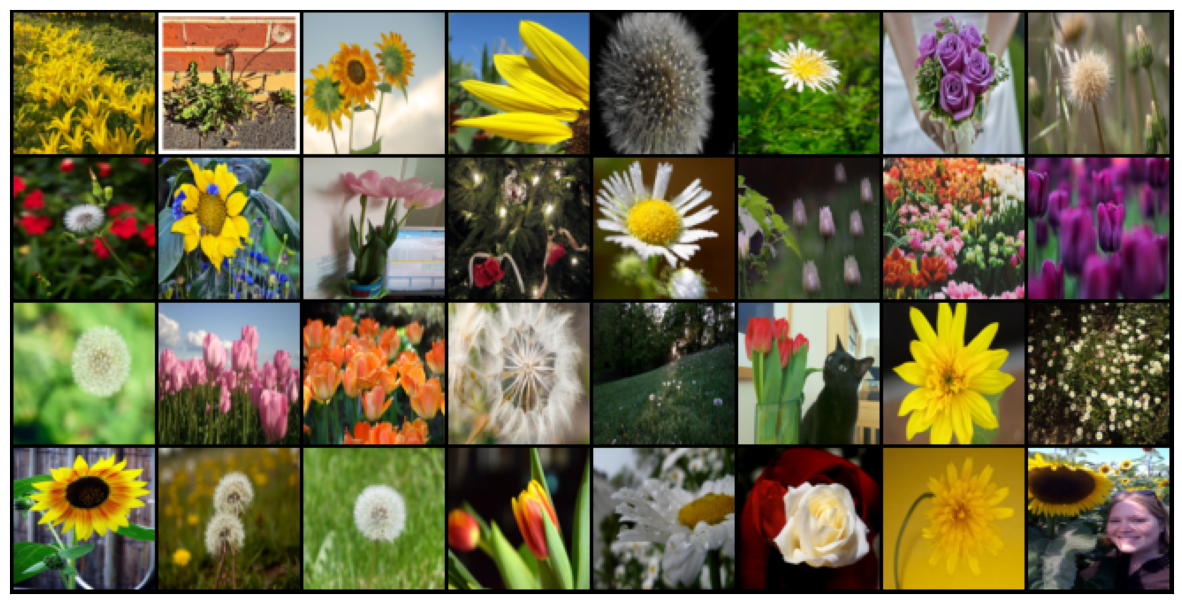

In [37]:
show_batch(dataloaders['training'])

Задаем модель и отправляем на вычислительный процессор.

In [38]:
 class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(5*5*128, 1600)
        self.fc2 = nn.Linear(1600, 3200)
        self.fc3 = nn.Linear(3200, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
model = CNN().to(device)

Выведем подробную детализацию модели.

In [39]:
! pip install torchinfo

In [41]:
from torchinfo import summary
summary(model, input_size=(10, 3, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [10, 10]                  --
├─Sequential: 1-1                        [10, 16, 40, 40]          --
│    └─Conv2d: 2-1                       [10, 16, 80, 80]          1,216
│    └─BatchNorm2d: 2-2                  [10, 16, 80, 80]          32
│    └─ReLU: 2-3                         [10, 16, 80, 80]          --
│    └─MaxPool2d: 2-4                    [10, 16, 40, 40]          --
├─Sequential: 1-2                        [10, 32, 20, 20]          --
│    └─Conv2d: 2-5                       [10, 32, 40, 40]          12,832
│    └─BatchNorm2d: 2-6                  [10, 32, 40, 40]          64
│    └─ReLU: 2-7                         [10, 32, 40, 40]          --
│    └─MaxPool2d: 2-8                    [10, 32, 20, 20]          --
├─Sequential: 1-3                        [10, 64, 10, 10]          --
│    └─Conv2d: 2-9                       [10, 64, 20, 20]          51,264
│   

In [42]:
optimizer = torch.optim.Adam(params = model.parameters())
criterion = nn.CrossEntropyLoss()

Создаем цикл обучения модели.

In [43]:
class ValueMeter(object):
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")

In [44]:
def accuracy(outputs, labels): # функция для подсчёта точности
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [45]:
def trainval(model, loaders, optimizer, epochs=10):
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs):
        for mode in ['training', 'validation']: # две фазы: тренировочная и валидационная

            with torch.set_grad_enabled(mode == 'training'):
                model.train() if mode == 'training' else model.eval() # режим тренировки - веса могут обновляться, режим валидации - веса заморожены
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device)
                    labels = labels.to(device)
                    bs = labels.shape[0]

                    preds = model(imgs)
                    loss = F.cross_entropy(preds, labels)
                    acc = accuracy(preds, labels)

                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)


                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем градиенты
                        loss.backward() # обратное распространение ошибки
                        optimizer.step() # обновление весов алгоритмом оптимизации
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

Запуск обучения модели.

In [47]:
loss_track, accuracy_track = trainval(model, dataloaders, optimizer, epochs=20)

100%|██████████| 81/81 [01:05<00:00,  1.24it/s]


[training] Epoch: 0.00. Loss: 1.18. Accuracy: 51.30% 


100%|██████████| 27/27 [00:10<00:00,  2.68it/s]


[validation] Epoch: 0.00. Loss: 1.13. Accuracy: 55.98% 


100%|██████████| 81/81 [01:03<00:00,  1.27it/s]


[training] Epoch: 1.00. Loss: 1.16. Accuracy: 52.36% 


100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


[validation] Epoch: 1.00. Loss: 1.13. Accuracy: 54.87% 


100%|██████████| 81/81 [01:03<00:00,  1.27it/s]


[training] Epoch: 2.00. Loss: 1.16. Accuracy: 52.78% 


100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


[validation] Epoch: 2.00. Loss: 1.18. Accuracy: 51.96% 


100%|██████████| 81/81 [01:09<00:00,  1.16it/s]


[training] Epoch: 3.00. Loss: 1.13. Accuracy: 54.19% 


100%|██████████| 27/27 [00:09<00:00,  2.71it/s]


[validation] Epoch: 3.00. Loss: 1.17. Accuracy: 52.97% 


100%|██████████| 81/81 [01:02<00:00,  1.29it/s]


[training] Epoch: 4.00. Loss: 1.12. Accuracy: 54.79% 


100%|██████████| 27/27 [00:10<00:00,  2.61it/s]


[validation] Epoch: 4.00. Loss: 1.19. Accuracy: 52.09% 


100%|██████████| 81/81 [01:13<00:00,  1.11it/s]


[training] Epoch: 5.00. Loss: 1.10. Accuracy: 55.77% 


100%|██████████| 27/27 [00:10<00:00,  2.65it/s]


[validation] Epoch: 5.00. Loss: 1.24. Accuracy: 51.56% 


100%|██████████| 81/81 [01:09<00:00,  1.17it/s]


[training] Epoch: 6.00. Loss: 1.09. Accuracy: 56.59% 


100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


[validation] Epoch: 6.00. Loss: 1.22. Accuracy: 52.79% 


100%|██████████| 81/81 [01:05<00:00,  1.24it/s]


[training] Epoch: 7.00. Loss: 1.07. Accuracy: 57.56% 


100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


[validation] Epoch: 7.00. Loss: 1.22. Accuracy: 52.93% 


100%|██████████| 81/81 [01:05<00:00,  1.24it/s]


[training] Epoch: 8.00. Loss: 1.05. Accuracy: 58.50% 


100%|██████████| 27/27 [00:09<00:00,  2.77it/s]


[validation] Epoch: 8.00. Loss: 1.20. Accuracy: 54.03% 


100%|██████████| 81/81 [01:06<00:00,  1.22it/s]


[training] Epoch: 9.00. Loss: 1.03. Accuracy: 59.36% 


100%|██████████| 27/27 [00:10<00:00,  2.64it/s]


[validation] Epoch: 9.00. Loss: 1.17. Accuracy: 55.23% 


100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


[training] Epoch: 10.00. Loss: 1.01. Accuracy: 60.15% 


100%|██████████| 27/27 [00:10<00:00,  2.52it/s]


[validation] Epoch: 10.00. Loss: 1.15. Accuracy: 55.96% 


100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


[training] Epoch: 11.00. Loss: 0.99. Accuracy: 61.02% 


100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


[validation] Epoch: 11.00. Loss: 1.12. Accuracy: 57.06% 


100%|██████████| 81/81 [01:04<00:00,  1.25it/s]


[training] Epoch: 12.00. Loss: 0.98. Accuracy: 61.77% 


100%|██████████| 27/27 [00:11<00:00,  2.45it/s]


[validation] Epoch: 12.00. Loss: 1.10. Accuracy: 58.02% 


100%|██████████| 81/81 [01:05<00:00,  1.23it/s]


[training] Epoch: 13.00. Loss: 0.96. Accuracy: 62.43% 


100%|██████████| 27/27 [00:10<00:00,  2.51it/s]


[validation] Epoch: 13.00. Loss: 1.11. Accuracy: 57.90% 


100%|██████████| 81/81 [01:10<00:00,  1.15it/s]


[training] Epoch: 14.00. Loss: 0.95. Accuracy: 63.04% 


100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


[validation] Epoch: 14.00. Loss: 1.09. Accuracy: 58.63% 


100%|██████████| 81/81 [01:06<00:00,  1.21it/s]


[training] Epoch: 15.00. Loss: 0.93. Accuracy: 63.61% 


100%|██████████| 27/27 [00:10<00:00,  2.47it/s]


[validation] Epoch: 15.00. Loss: 1.09. Accuracy: 58.83% 


100%|██████████| 81/81 [01:07<00:00,  1.20it/s]


[training] Epoch: 16.00. Loss: 0.92. Accuracy: 64.22% 


100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


[validation] Epoch: 16.00. Loss: 1.07. Accuracy: 59.38% 


100%|██████████| 81/81 [01:06<00:00,  1.22it/s]


[training] Epoch: 17.00. Loss: 0.91. Accuracy: 64.83% 


100%|██████████| 27/27 [00:10<00:00,  2.51it/s]


[validation] Epoch: 17.00. Loss: 1.08. Accuracy: 59.55% 


100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


[training] Epoch: 18.00. Loss: 0.89. Accuracy: 65.36% 


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


[validation] Epoch: 18.00. Loss: 1.07. Accuracy: 60.04% 


100%|██████████| 81/81 [01:04<00:00,  1.25it/s]


[training] Epoch: 19.00. Loss: 0.88. Accuracy: 65.92% 


100%|██████████| 27/27 [00:10<00:00,  2.52it/s]

[validation] Epoch: 19.00. Loss: 1.06. Accuracy: 60.61% 


Оценим качество итоговой модели. Построим кривые обучения и валидации.

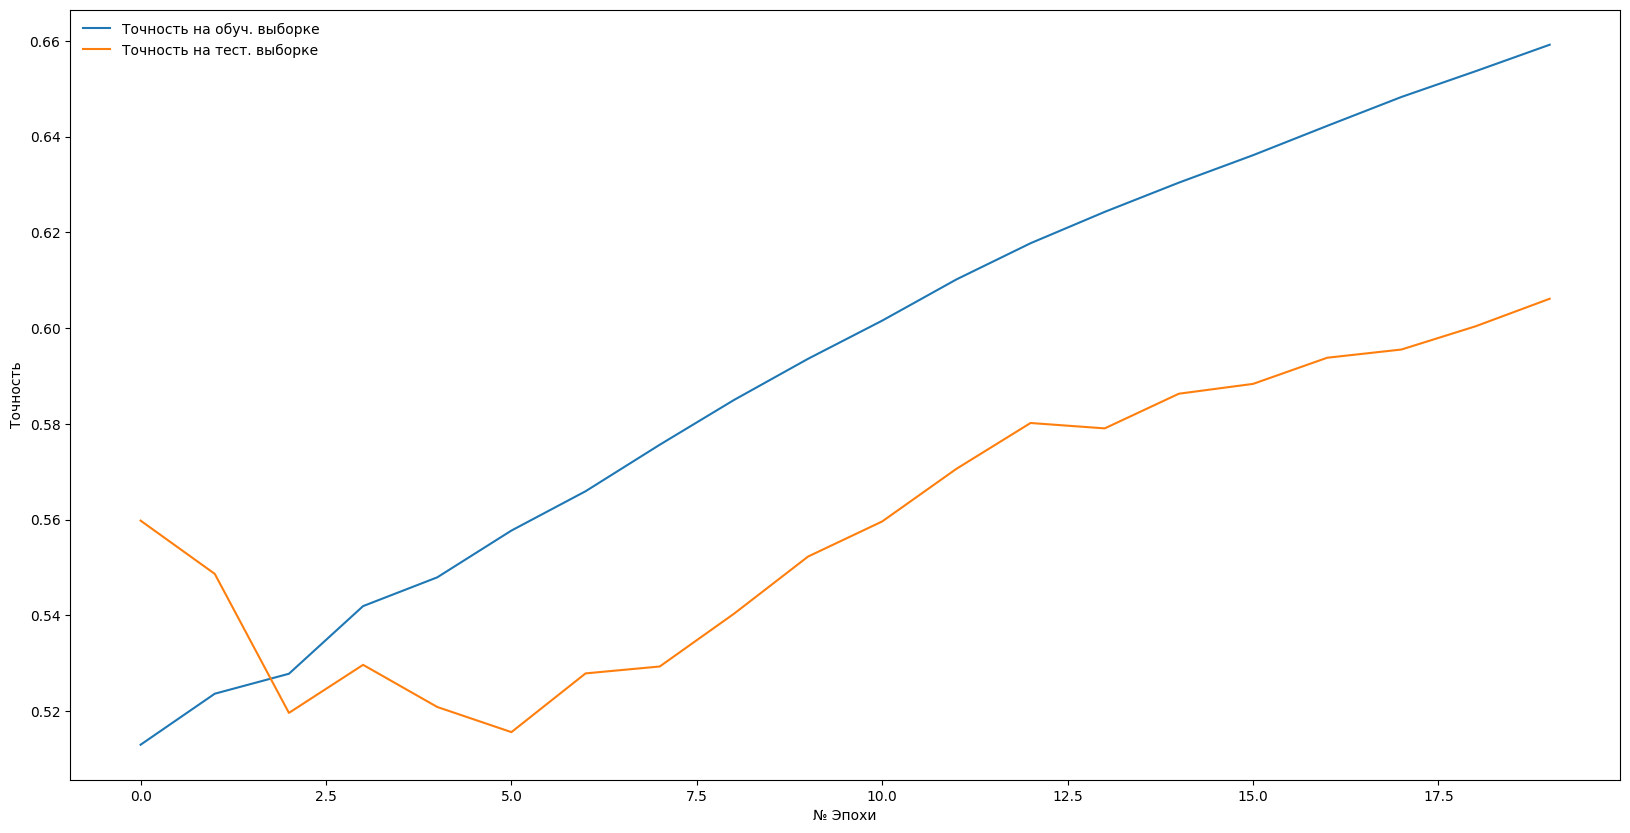

In [48]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(accuracy_track['training'],label="Точность на обуч. выборке")
plt.plot(accuracy_track['validation'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

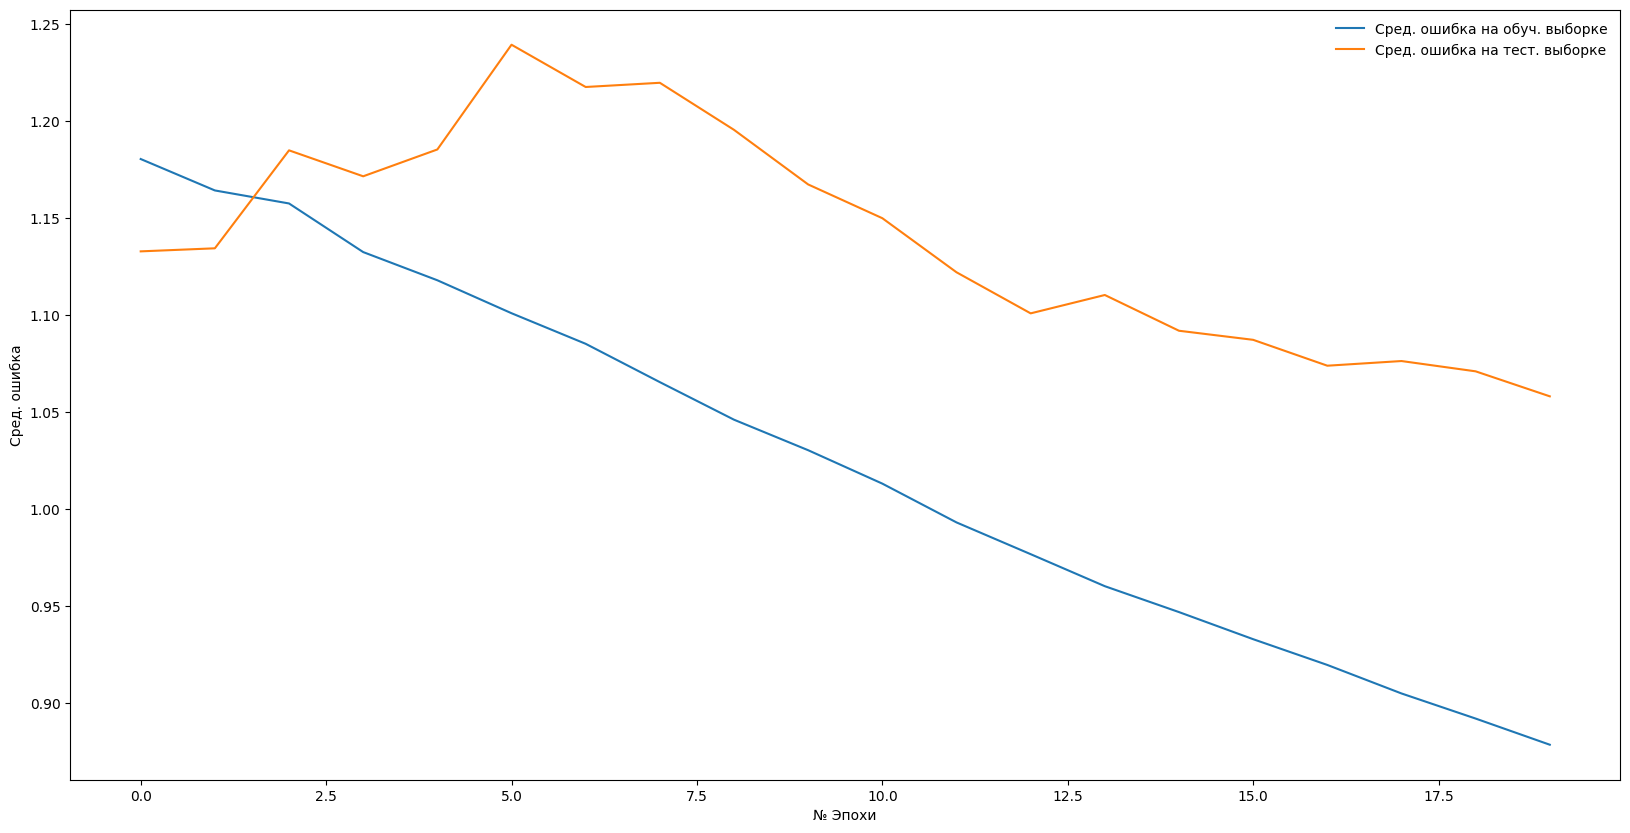

In [49]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(loss_track['training'],label="Сред. ошибка на обуч. выборке")
plt.plot(loss_track['validation'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

Полученная модель показала удовлетворительные результаты. Простая модель CNN подошла для обучения на исходном наборе данных.